In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Train + Test Matlab.mat', 'csvTestLabel 10k x 1.csv', 'csvTestImages 10k x 784.csv', 'Arabic Handwritten Digits Dataset CSV', 'csvTrainLabel 60k x 1.csv', 'csvTrainImages 60k x 784.csv']


Disclaimer: This repo is a mimicking to the way Mr. Yassine Ghouzam followed in his [repo](https://www.kaggle.com/atheeralattar/introduction-to-cnn-keras-0-997-top-6-60909e/edit), I liked the way he streamlined his work and wanted to reproduce that. I give him all the credit.

# Introduction to Arabic Digits Recognizer
### Atheer Al Attar, EPROD
#### Mar 20, 2019

* **1. Introduction:**
* **2. Data Preparation**
    * 2.1 Load data
    * 2.2 Check for null and missing values
    * 2.3 Normalization
    * 2.4 Reshape
    * 2.5 Label encoding
    * 2.6 Split training and valdiation set
* **3.CNN**
    * 3.1 What is the difference between the FILTER and the KERNEL
    * 3.2. Define the model
    * 3.3. Set the optimizer and annealer
    * 3.4. Data augmentation
* **4. Evaluate the model**
    * 4.1 Training and validation curves
    * 4.2 Confusion matrix
* **5. Prediction and submition**
    * 5.1 Predict and Submit results

# 1.Introduction
I always wanted to enter these Kaggle competitions and I find it too hard to get in, so I started watching the videos of the Deep Learning Course and followed up the competition  of the digit recognizer steps and here I am writing my first repo. I found the way Yassine followed in his repo is very clear and tidy and that's why I wanted to adopt it in all my coming competitions. I will try to work on this competition on my own pc and then will transfer the files to Kaggle to see how it goes. My laptop is MacBook 2.5 GHz Intel Core i7 and 16GB of RAM



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 2. Data Preparation
## 2.1. Data Loading

In [2]:
# Load training and testing data
Y_train = pd.read_csv('input/Arabic Handwritten Digits Dataset CSV/csvTrainLabel 60k x 1.csv')
X_train = pd.read_csv('input/csvTrainImages 60k x 784.csv')
y_test = pd.read_csv('input/Arabic Handwritten Digits Dataset CSV/csvTestLabel 10k x 1.csv')
test = pd.read_csv('input/csvTestImages 10k x 784.csv')


0
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
0    5999
Name: count, dtype: int64

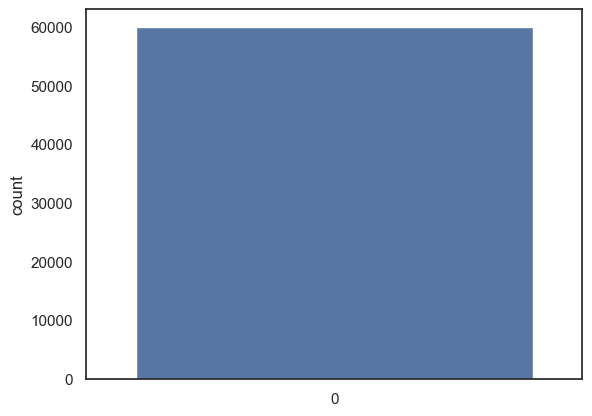

In [3]:
g=sns.countplot(Y_train.iloc[:,0])
Y_train=Y_train.iloc[:,0]
Y_train.value_counts()

## 2.2. Checking for the NULL values

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 2.3. Normalization
In order to eliminate the effect of the colors and illumination all the data will be normalized to 0-1

In [6]:
X_train=X_train/255.0
test=test/255.0

## 2.4. Reshaping
The current dimension of the X_train variable is 784 columns and one row. We will reshape the data to be in a square format (28 x 28 x 1 canal) 

In [7]:
X_train=X_train.values.reshape(-1, 28,28,1)
test=test.values.reshape(-1, 28, 28, 1)

## 2.5. Label encoding
In this step we will turn the 0-9 labels into a binary like coding, i.e. 2 <- [0,0,1,0,0,0,0,0,0] and so on.

In [8]:
Y_train=to_categorical(Y_train, num_classes=10)

## 2.6. Split training and validation sets
You need to make sure that you are not created a non balanced datasets when splitting your data into test and validation. 

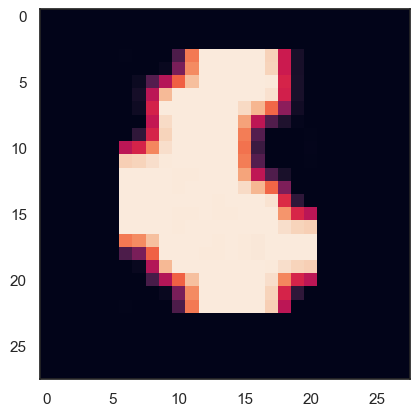

In [9]:
random_seed=2
X_train,X_val,Y_train,Y_val=train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)
g=plt.imshow(X_train[0][:,:,0])

# 3. CNN
## 3.1. What is the difference between the FILTER and the KERNEL
### 3.1.1. **Filters**: Are set of weights mulitplied by the part of the input vector in an elementwise manner and then the product will be summed up. There are many types of filters each is detecting a specific feature in the input data. The picture below from towardsdatascience shows the way filters work.
![](https://cdn-images-1.medium.com/max/800/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

### 3.1.2. **Kernels** The kernel refers to the area of the application the filter uses each time we perform a convolution on the input data. Check out the picture below from towardsdatascidnce.
![](https://cdn-images-1.medium.com/max/800/1*BMngs93_rm2_BpJFH2mS0Q.gif)

And to see what filters do in real, check out this tranformation by a Horizontal Sobel Kernel.

![](https://cdn-images-1.medium.com/max/1200/1*wju0Urp6KpAT11wktTp5Sg.png)

There other termonilogy in the CNN like **strides** and **padding** you can get a full detailed overview in [this](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) article.


## 3.2. Define the model
*Most of the information below is borrowed from the original author*
### 3.2.1. **MaxPooling**
It's the process of downsampling the input data through a max filter that is not over lapping on sub regions. The picture below from computersciencewiki illustrates the maxPool filter.
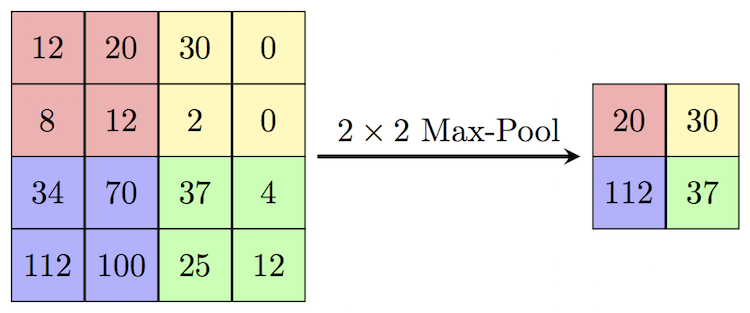

### 3.2.2. **Dropout**
Dropout is a method to reduce the overfitting chances in model optimization by randomly dropping some neruons by setting their weights to zero. 






In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Set the ANN model
model_ann = Sequential()

# Flatten the input shape to match the flattened output from CNN
model_ann.add(Flatten(input_shape=(28, 28, 1)))

# Replace Conv2D layers with Dense layers
model_ann.add(Dense(32, activation='relu'))
model_ann.add(Dense(32, activation='relu'))
model_ann.add(Dense(64, activation='relu'))
model_ann.add(Dense(64, activation='relu'))

# Replace MaxPool2D and Dropout layers (not applicable in ANN)
# If you want to reduce the number of parameters, you can use Dropout in Dense layers

# Flatten layer remains the same
# Dense layer with 256 units
model_ann.add(Dense(256, activation='relu'))

# Dropout layer
model_ann.add(Dropout(0.5))

# Output layer remains the same
model_ann.add(Dense(10, activation='softmax'))


## 3.3. Setting the Optimizer and the Annealer
This step is needed to evaluate the algorithm, loss, and the optimization process (Yassine)


In [15]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model_ann.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs=10
batch_size=86


## 3.4. Data Augmentation
Basically the data augmentation is a way to reduce the bias in the data and same time to increase your data pool. By introduce several data tranformation to the data sets (Shifting, Cropping, Rotating...)

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [17]:
# Fit the model
history = model_ann.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
627/627 - 33s - loss: 0.2072 - accuracy: 0.9403 - val_loss: 0.0873 - val_accuracy: 0.9745 - lr: 0.0010 - 33s/epoch - 52ms/step
Epoch 2/10
627/627 - 31s - loss: 0.1561 - accuracy: 0.9549 - val_loss: 0.0872 - val_accuracy: 0.9733 - lr: 0.0010 - 31s/epoch - 49ms/step
Epoch 3/10
627/627 - 35s - loss: 0.1346 - accuracy: 0.9627 - val_loss: 0.0656 - val_accuracy: 0.9787 - lr: 0.0010 - 35s/epoch - 56ms/step
Epoch 4/10
627/627 - 34s - loss: 0.1232 - accuracy: 0.9650 - val_loss: 0.0707 - val_accuracy: 0.9810 - lr: 0.0010 - 34s/epoch - 54ms/step
Epoch 5/10
627/627 - 32s - loss: 0.1147 - accuracy: 0.9680 - val_loss: 0.0607 - val_accuracy: 0.9810 - lr: 0.0010 - 32s/epoch - 52ms/step
Epoch 6/10
627/627 - 31s - loss: 0.1107 - accuracy: 0.9702 - val_loss: 0.0560 - val_accuracy: 0.9842 - lr: 0.0010 - 31s/epoch - 50ms/step
Epoch 7/10
627/627 - 30s - loss: 0.1082 - accuracy: 0.9705 - val_loss: 0.0791 - val_accuracy: 0.9765 - lr: 0.0010 - 30s/epoch - 49ms/step
Epoch 8/10
627/627 - 31s - loss: 0

In [18]:
# Save the model
model_ann.save("ANNAdigits.h5")

## 4. Evaluate the model
### 4.1. Training and Validation curves

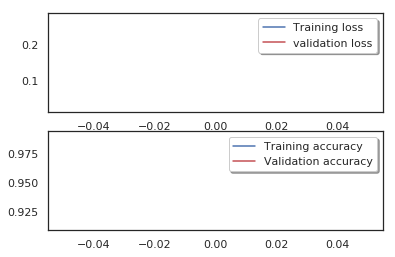

In [15]:

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2. Confusion Matrix

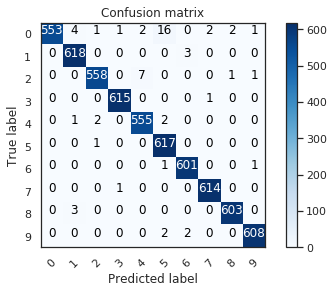

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

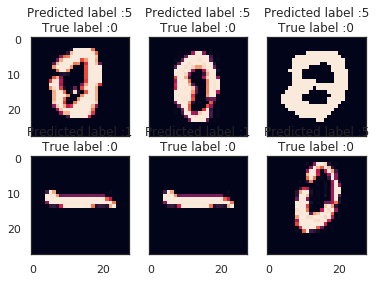

In [17]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [18]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [19]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)